# Task 2 — Technical Indicators & Price Preparation

**Goals**
- Load historical stock price CSVs
- Compute technical indicators: MA20, MA50, RSI14, MACD (and signal)
- Compute daily returns and volatility
- Save processed CSVs for later correlation with news sentiment
- Provide plots for quick inspection



In [1]:
# Standard imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 50)

# Directory where raw CSV files live
DATA_DIR = Path("../yfinance_data/Data")  

OUT_DIR = Path("../data/processed/price_indicators")
OUT_DIR.mkdir(parents=True, exist_ok=True)


Attempt to import `talib` for indicators. If not available,  use pure-Pandas implementations:
- MA (rolling mean) — native
- RSI — implemented with Wilder smoothing
- MACD — EMA-based calculation implemented with pandas


In [2]:

USE_TALIB = False
try:
    import talib
    USE_TALIB = True
    print("Using talib for indicators.")
except Exception as e:
    print("talib not available — using pandas fallback. Error:", e)

# Fallback RSI implementation (Wilder smoothing)
def rsi_wilder(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # First average
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    # Use Wilder smoothing for rest
    avg_gain = avg_gain.copy()
    avg_loss = avg_loss.copy()
    for i in range(period, len(series)):
        if i == period:
            prev_gain = avg_gain.iloc[i]
            prev_loss = avg_loss.iloc[i]
        else:
            prev_gain = (prev_gain * (period - 1) + gain.iloc[i]) / period
            prev_loss = (prev_loss * (period - 1) + loss.iloc[i]) / period
        avg_gain.iloc[i] = prev_gain
        avg_loss.iloc[i] = prev_loss

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Fallback MACD implementation (using EMA)
def macd_pandas(series: pd.Series, fast: int = 12, slow: int = 26, signal: int = 9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist


Using talib for indicators.


Then will:
- Iterate all CSV files in `DATA_DIR`
- For each file compute: MA20, MA50, RSI14, MACD, daily returns, 20-day rolling volatility
- Save processed CSV to `../data/processed/price_indicators/<SYMBOL>_processed.csv`
- Plot a diagnostic chart (Close, MA20, MA50) and RSI for quick inspection


In [3]:
csv_files = sorted(DATA_DIR.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {DATA_DIR}. Please point DATA_DIR to your CSV files.")

processed = {}
for path in csv_files:
    symbol = path.stem.upper()
    print(f"Processing {symbol} — {path}")
    df = pd.read_csv(path, parse_dates=["Date"])
    df = df.sort_values("Date").reset_index(drop=True)

    # Ensure consistent column names
    # Many yfinance CSVs use 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
    if "Close" not in df.columns:
        raise KeyError(f"Close column not found in {path}")

    # Daily returns
    df["return"] = df["Close"].pct_change()

    # Moving averages
    df["MA20"] = df["Close"].rolling(window=20).mean()
    df["MA50"] = df["Close"].rolling(window=50).mean()

    # Volatility: rolling 20-day std of returns (annualized optional: *sqrt(252))
    df["volatility_20d"] = df["return"].rolling(window=20).std()

    # RSI
    if USE_TALIB:
        df["RSI14"] = talib.RSI(df["Close"].values, timeperiod=14)
    else:
        df["RSI14"] = rsi_wilder(df["Close"], period=14)

    # MACD
    if USE_TALIB:
        macd, signal, hist = talib.MACD(df["Close"].values, fastperiod=12, slowperiod=26, signalperiod=9)
        df["MACD"] = macd
        df["MACD_signal"] = signal
        df["MACD_hist"] = hist
    else:
        macd, signal, hist = macd_pandas(df["Close"])
        df["MACD"] = macd
        df["MACD_signal"] = signal
        df["MACD_hist"] = hist

    # Drop rows with NA from the initial windows to keep CSV lighter (optional)
    df_ready = df.copy()  # keep full for debug; if you want to dropna -> df.dropna(inplace=True)

    # Save processed file
    out_file = OUT_DIR / f"{symbol}_processed.csv"
    df_ready.to_csv(out_file, index=False)
    print(f"Saved processed -> {out_file}")

    processed[symbol] = df_ready

print("All files processed.")


Processing AAPL — ..\yfinance_data\Data\AAPL.csv
Saved processed -> ..\data\processed\price_indicators\AAPL_processed.csv
Processing AMZN — ..\yfinance_data\Data\AMZN.csv
Saved processed -> ..\data\processed\price_indicators\AMZN_processed.csv
Processing GOOG — ..\yfinance_data\Data\GOOG.csv
Saved processed -> ..\data\processed\price_indicators\GOOG_processed.csv
Processing META — ..\yfinance_data\Data\META.csv
Saved processed -> ..\data\processed\price_indicators\META_processed.csv
Processing MSFT — ..\yfinance_data\Data\MSFT.csv
Saved processed -> ..\data\processed\price_indicators\MSFT_processed.csv
Processing NVDA — ..\yfinance_data\Data\NVDA.csv
Saved processed -> ..\data\processed\price_indicators\NVDA_processed.csv
All files processed.


## Diagnostics
 plot Close+MA and RSI for each symbol for visual inspection.


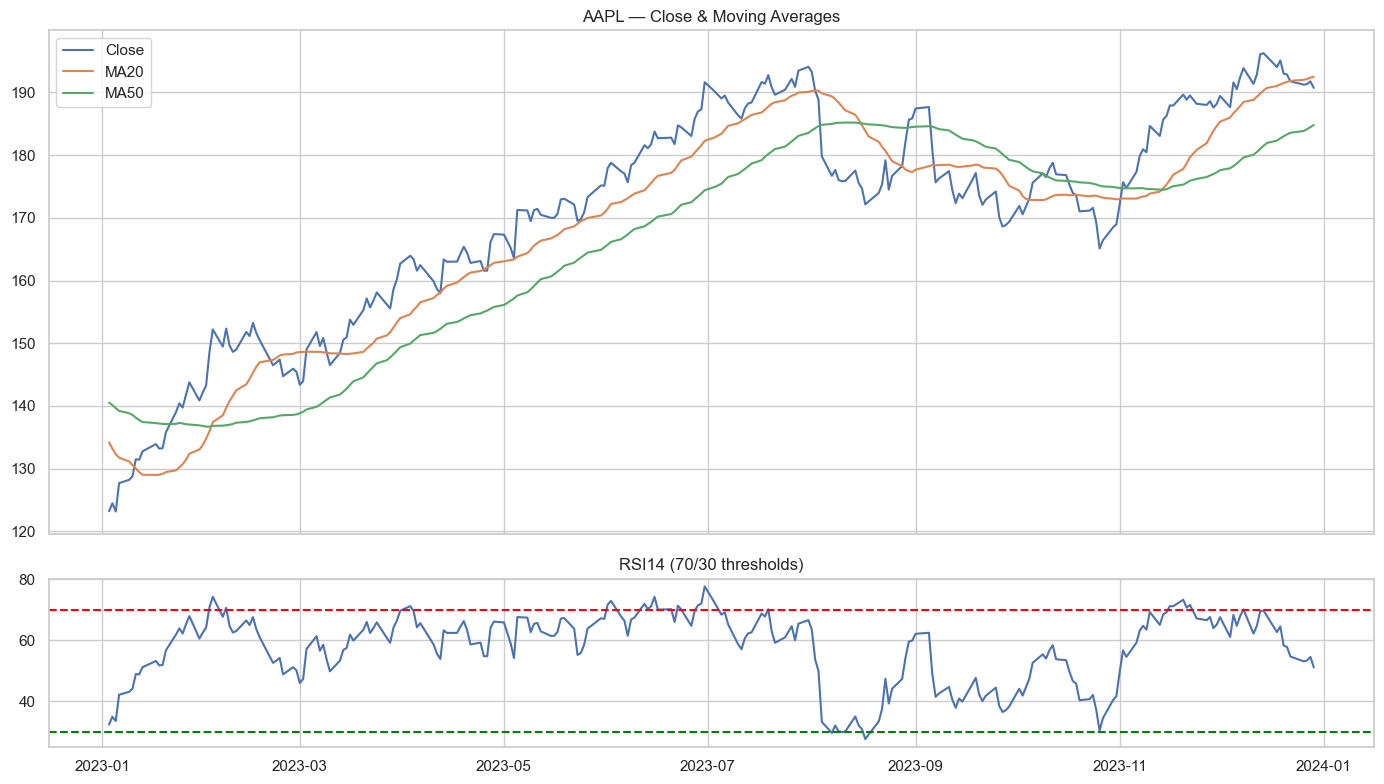

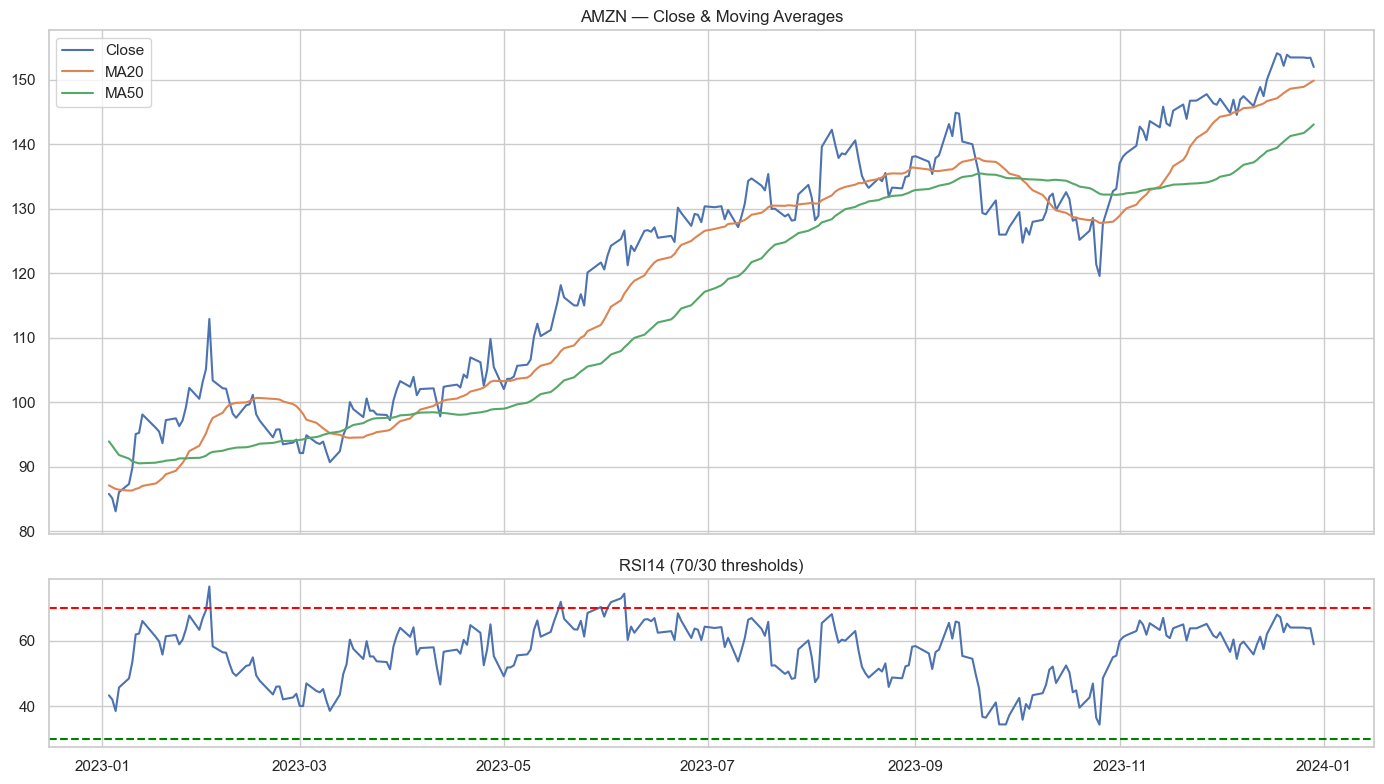

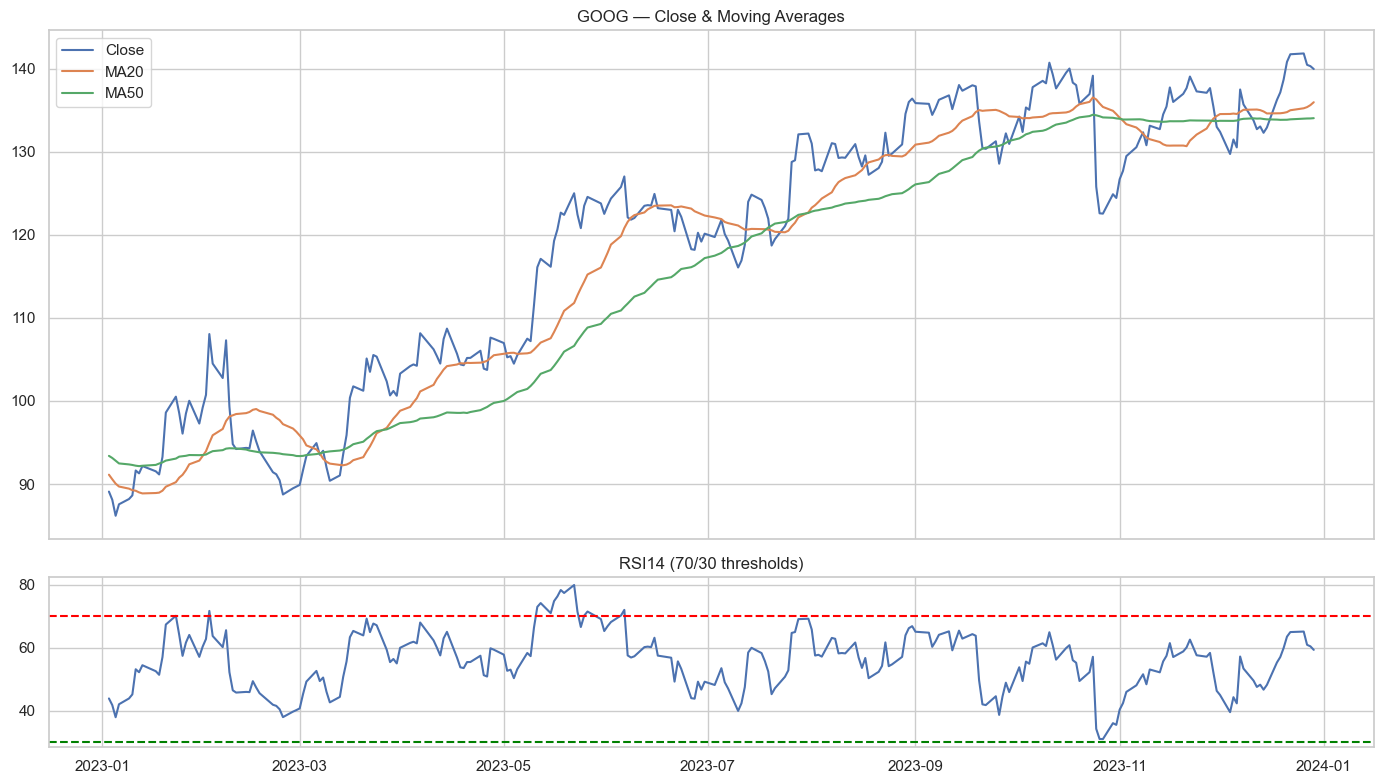

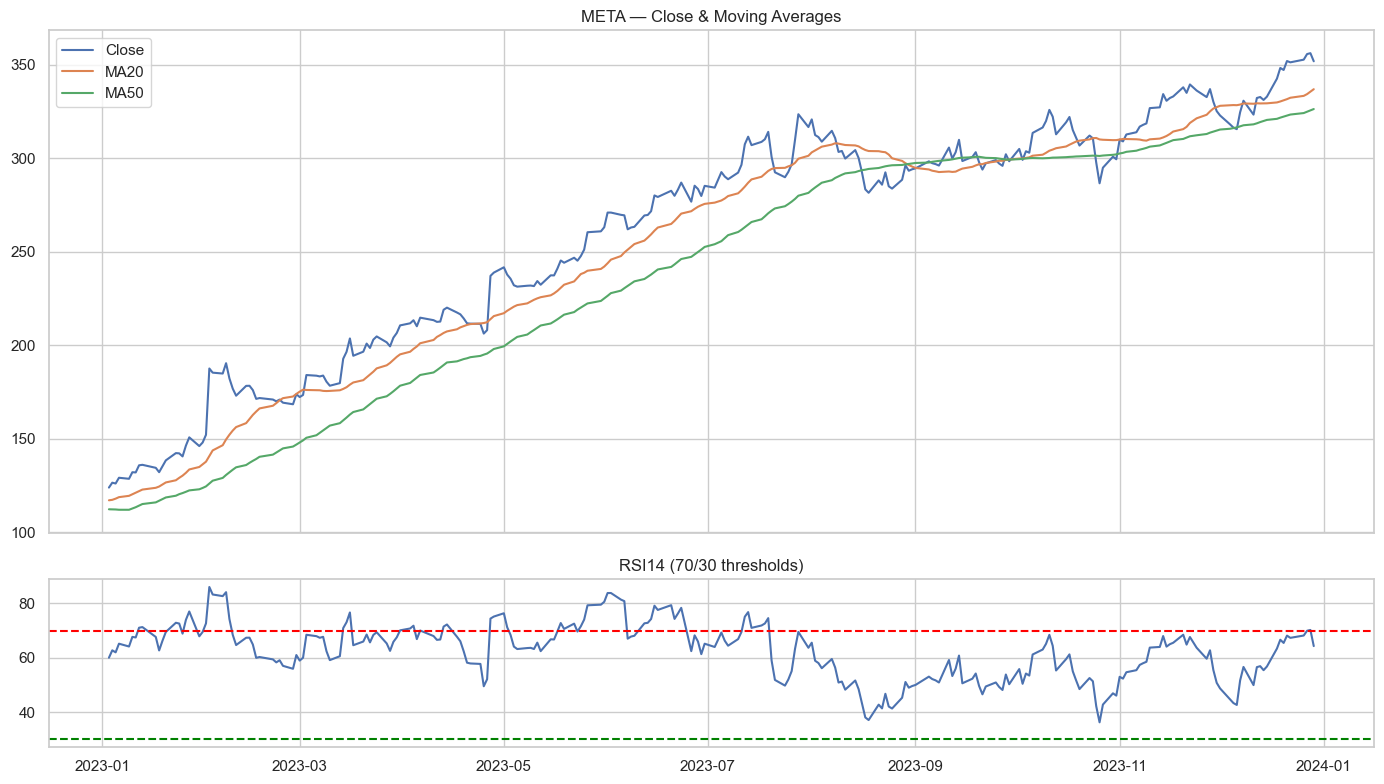

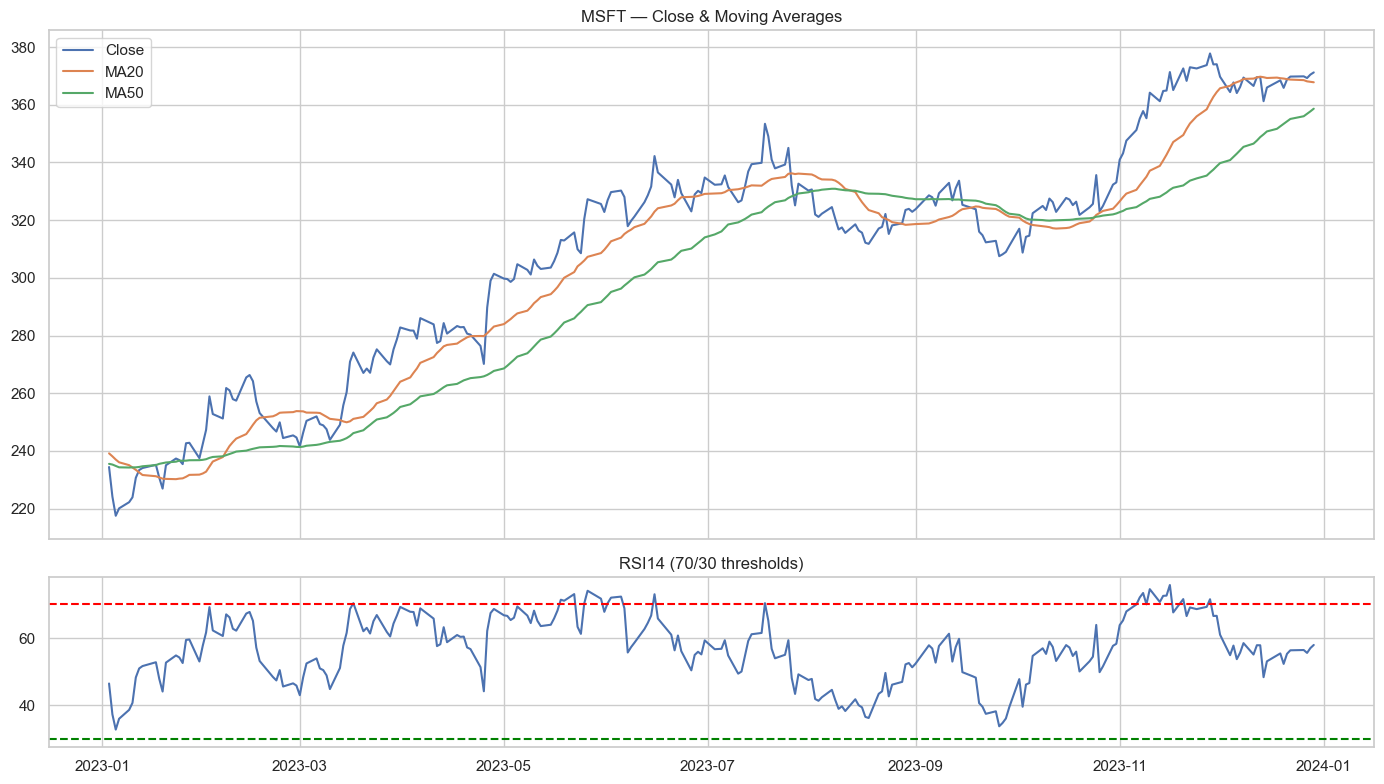

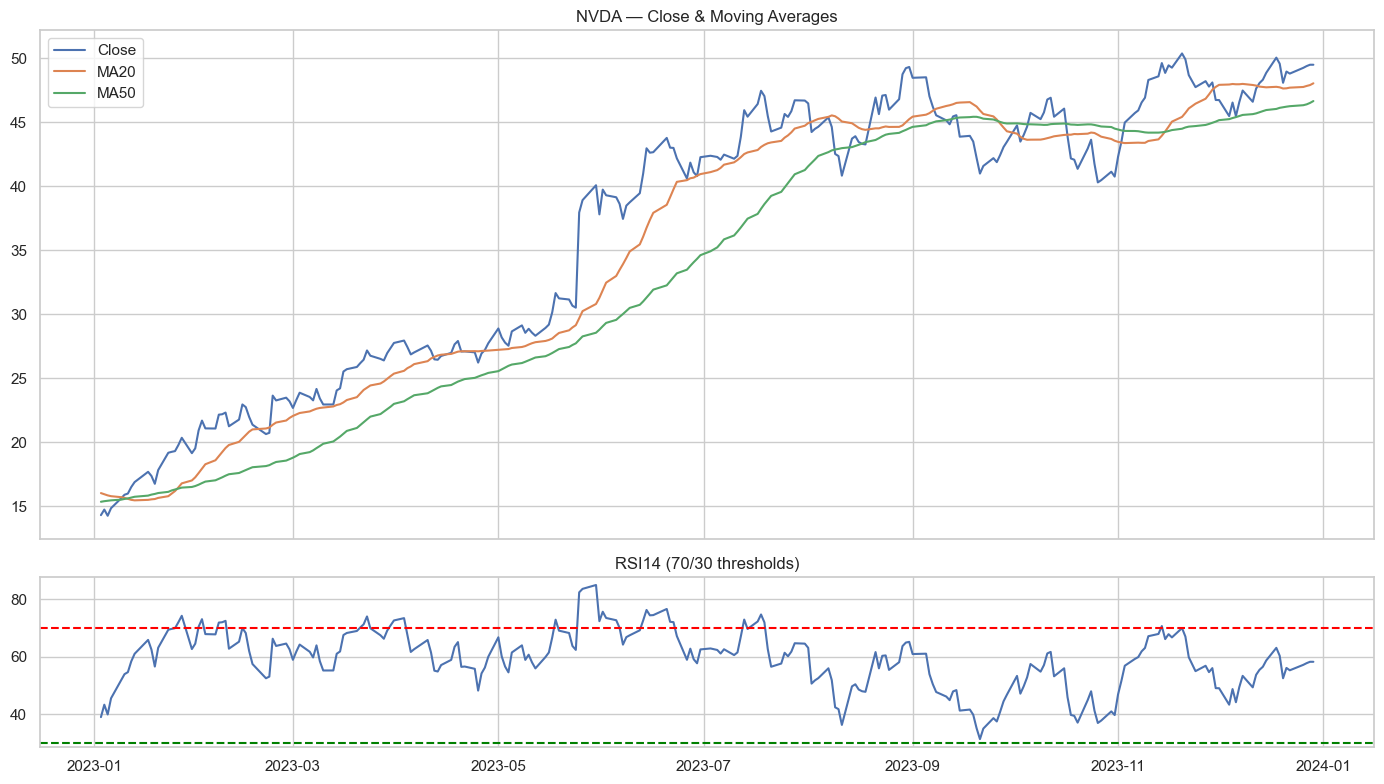

In [4]:
for sym, df in processed.items():
    # sample latest window for readability
    df_plot = df.tail(250)  # last ~1 year of daily data

    fig, ax = plt.subplots(2, 1, figsize=(14,8), sharex=True,
                           gridspec_kw={"height_ratios":[3,1]})

    ax[0].plot(df_plot["Date"], df_plot["Close"], label="Close")
    ax[0].plot(df_plot["Date"], df_plot["MA20"], label="MA20")
    ax[0].plot(df_plot["Date"], df_plot["MA50"], label="MA50")
    ax[0].set_title(f"{sym} — Close & Moving Averages")
    ax[0].legend()

    ax[1].plot(df_plot["Date"], df_plot["RSI14"], label="RSI14")
    ax[1].axhline(70, color="red", linestyle="--")
    ax[1].axhline(30, color="green", linestyle="--")
    ax[1].set_title("RSI14 (70/30 thresholds)")

    plt.tight_layout()
    plt.show()


## Save Combined Returns Table

Create a combined DataFrame of daily returns aligned by Date for all symbols — useful for correlation analysis and later modeling.


Saved combined returns to ..\data\processed\price_indicators\combined_returns.csv


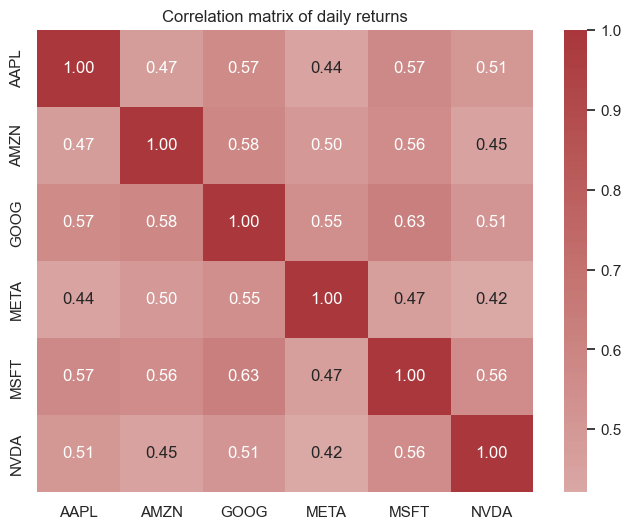

In [6]:
# Build combined returns DataFrame aligned by Date
returns_df = pd.DataFrame()
for sym, df in processed.items():
    temp = df[["Date", "return"]].rename(columns={"return": sym})
    if returns_df.empty:
        returns_df = temp
    else:
        returns_df = returns_df.merge(temp, on="Date", how="outer")

returns_df = returns_df.sort_values("Date").reset_index(drop=True)
returns_df_out = OUT_DIR / "combined_returns.csv"
returns_df.to_csv(returns_df_out, index=False)
print("Saved combined returns to", returns_df_out)

# Quick correlation heatmap
corr = returns_df.drop(columns=["Date"]).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix of daily returns")
plt.show()


# Next
- Now I have processed price files per ticker in `data/processed/price_indicators/`
- Combined returns table saved to `combined_returns.csv`
- Next (Task 3): run sentiment analysis on news headlines and compute correlations between aggregated daily sentiment and these returns.


In [7]:
output_path = "../data/processed/price_indicators.csv"
os.makedirs("../data/processed", exist_ok=True)
df.to_csv(output_path, index=False)

output_path


'../data/processed/price_indicators.csv'